## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

## Exploring the data

In [2]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../neuralnets/aclImdb/train')
test_ds = text_dataset_from_directory('../neuralnets/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 25001 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


/home/jaidevd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [3]:
pd.options.display.max_colwidth = 200
dfTrain.head()

,text,label
0,I saw this film 12 years ago on TNT. It was Susanah York's Birthday and they were showing this film as a double feature with Tom Jones (1963). I have not seen this film on TV since. I took interes...,1
1,"Trot out every stereotype and misrepresentation you've heard about semi-devout Mormons, and you'll see they've all starred in this ridiculous excuse for a film. Finally Kurt Hale's fortunes have c...",0
2,"When I saw this trailer on TV I was surprised. In May of 2008 I was at Six Flags in New Jersey and this was showing at a 4-D attraction (you know, the attraction that the seats move). I take it th...",0
3,"Truly terrible, pretentious, endless film. Director Bellocchio seems to be infatuated with the pretty face and figure of his actress Detmers - and who can blame him? But maybe, just maybe, he shou...",0
4,"This is one of the best movies I have ever seen. I feel greatly touched by the theme the movie intends to convey. One sentence that keeps coming up on my mind is that ""history repeats itself"". Lif...",1


In [4]:
print(dfTrain.loc[0, 'text'])

I saw this film 12 years ago on TNT. It was Susanah York's Birthday and they were showing this film as a double feature with Tom Jones (1963). I have not seen this film on TV since. I took interest in seeing this film because one of the stars is the very funny and talented Jim Dale, as Lusty the sailor. I believe that Dale now does the narration of the Harry Potter books on Casette, but anyway he is quite funny. This is a fast paced comedy. It is not on VHS or DVD. Columbia Pictures should go through their film collection, and consider restoring and releasing this film to DVD. Christopher Plummer is hilarious as Lord Fopington, Ian Bannen is also quite humorous as Ramble the sailor. This is a bawdy comedy, the kind of film one no longer sees, with great production values. ***1/2 stars out of ****


## Tokenize the text

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [6]:
print(train_sequences[0])

[10, 216, 11, 19, 1685, 150, 593, 20, 18511, 9, 13, 52009, 12997, 3366, 2, 33, 68, 797, 11, 19, 14, 3, 1402, 788, 16, 824, 1526, 7364, 10, 25, 21, 107, 11, 19, 20, 245, 234, 10, 559, 599, 8, 316, 11, 19, 85, 28, 4, 1, 378, 6, 1, 52, 160, 2, 1016, 1238, 10086, 14, 17633, 1, 7262, 10, 260, 12, 10086, 147, 124, 1, 2553, 4, 1, 1331, 6436, 1148, 20, 52010, 18, 550, 26, 6, 176, 160, 11, 6, 3, 699, 1780, 209, 9, 6, 21, 20, 1853, 39, 285, 7093, 1264, 141, 137, 140, 65, 19, 1588, 2, 1127, 19500, 2, 6985, 11, 19, 5, 285, 1365, 8775, 6, 639, 14, 1631, 52011, 3462, 21906, 6, 79, 176, 1975, 14, 14360, 1, 7262, 11, 6, 3, 17634, 209, 1, 240, 4, 19, 28, 54, 1203, 1079, 16, 84, 362, 1231, 297, 238, 378, 43, 4]


In [7]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['i', 'saw', 'this', 'film', '12', 'years', 'ago', 'on', 'tnt', 'it', 'was', 'susanah', "york's", 'birthday', 'and', 'they', 'were', 'showing', 'this', 'film', 'as', 'a', 'double', 'feature', 'with', 'tom', 'jones', '1963', 'i', 'have', 'not', 'seen', 'this', 'film', 'on', 'tv', 'since', 'i', 'took', 'interest', 'in', 'seeing', 'this', 'film', 'because', 'one', 'of', 'the', 'stars', 'is', 'the', 'very', 'funny', 'and', 'talented', 'jim', 'dale', 'as', 'lusty', 'the', 'sailor', 'i', 'believe', 'that', 'dale', 'now', 'does', 'the', 'narration', 'of', 'the', 'harry', 'potter', 'books', 'on', 'casette', 'but', 'anyway', 'he', 'is', 'quite', 'funny', 'this', 'is', 'a', 'fast', 'paced', 'comedy', 'it', 'is', 'not', 'on', 'vhs', 'or', 'dvd', 'columbia', 'pictures', 'should', 'go', 'through', 'their', 'film', 'collection', 'and', 'consider', 'restoring', 'and', 'releasing', 'this', 'film', 'to', 'dvd', 'christopher', 'plummer', 'is', 'hilarious', 'as', 'lord', 'fopington', 'ian', 'bannen', 'is

In [8]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [9]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [10]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [11]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [12]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [13]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=128, epochs=30
)

Epoch 1/30
196/196 [==============================] - 7s 38ms/step - loss: 0.6275 - accuracy: 0.6633 - val_loss: 0.6118 - val_accuracy: 0.6712
Epoch 2/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5591 - accuracy: 0.7173 - val_loss: 0.5374 - val_accuracy: 0.7392
Epoch 3/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5304 - accuracy: 0.7385 - val_loss: 0.5247 - val_accuracy: 0.7438
Epoch 4/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5183 - accuracy: 0.7439 - val_loss: 0.5114 - val_accuracy: 0.7570
Epoch 5/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5115 - accuracy: 0.7487 - val_loss: 0.5037 - val_accuracy: 0.7602
Epoch 6/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5051 - accuracy: 0.7508 - val_loss: 0.4981 - val_accuracy: 0.7630
Epoch 7/30
196/196 [==============================] - 7s 37ms/step - loss: 0.5029 - accuracy: 0.7542 - val_loss: 0.5003 - val_accuracy: 0.7610

# Train with a different set of word embeddings

In [14]:
glove_wiki = KeyedVectors.load_word2vec_format('data/glove.6B.300d.txt', binary=False, no_header=True)

In [15]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [16]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=128, epochs=30
)

Epoch 1/30
196/196 [==============================] - 17s 87ms/step - loss: 0.6228 - accuracy: 0.6785 - val_loss: 0.5328 - val_accuracy: 0.7715
Epoch 2/30
196/196 [==============================] - 17s 87ms/step - loss: 0.4774 - accuracy: 0.7933 - val_loss: 0.4553 - val_accuracy: 0.7990
Epoch 3/30
196/196 [==============================] - 17s 87ms/step - loss: 0.4341 - accuracy: 0.8148 - val_loss: 0.4147 - val_accuracy: 0.8275
Epoch 4/30
196/196 [==============================] - 17s 87ms/step - loss: 0.4154 - accuracy: 0.8221 - val_loss: 0.4143 - val_accuracy: 0.8237
Epoch 5/30
196/196 [==============================] - 17s 87ms/step - loss: 0.4066 - accuracy: 0.8279 - val_loss: 0.3947 - val_accuracy: 0.8328
Epoch 6/30
196/196 [==============================] - 17s 87ms/step - loss: 0.4000 - accuracy: 0.8299 - val_loss: 0.3867 - val_accuracy: 0.8371
Epoch 7/30
196/196 [==============================] - 17s 87ms/step - loss: 0.3946 - accuracy: 0.8298 - val_loss: 0.4055 - val_accuracy:

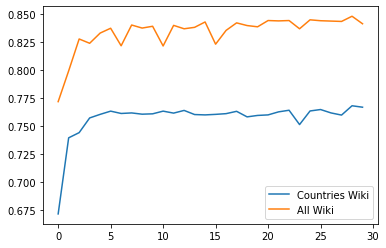

In [17]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()